# The Wine Quality Dataset - Outliers and Anomalies

### Library Import

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from venny4py.venny4py import *
import klib

from sklearn.preprocessing import StandardScaler
from scipy.stats import median_abs_deviation as mad 

from pyod.models.ecod import ECOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder

pd.set_option('display.max_columns', None)

In [113]:
color_1 = 'olivedrab'
color_2 = 'darkred'

In [114]:
# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Load Data
- https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

In [115]:
df = pd.read_csv(r'wine.data', header=None, names = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids',
                                                    'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'OD280_OD315_of_diluted_wines', 'proline' ])

In [116]:
df = df.reset_index(drop=True)
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280_OD315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


### EDA

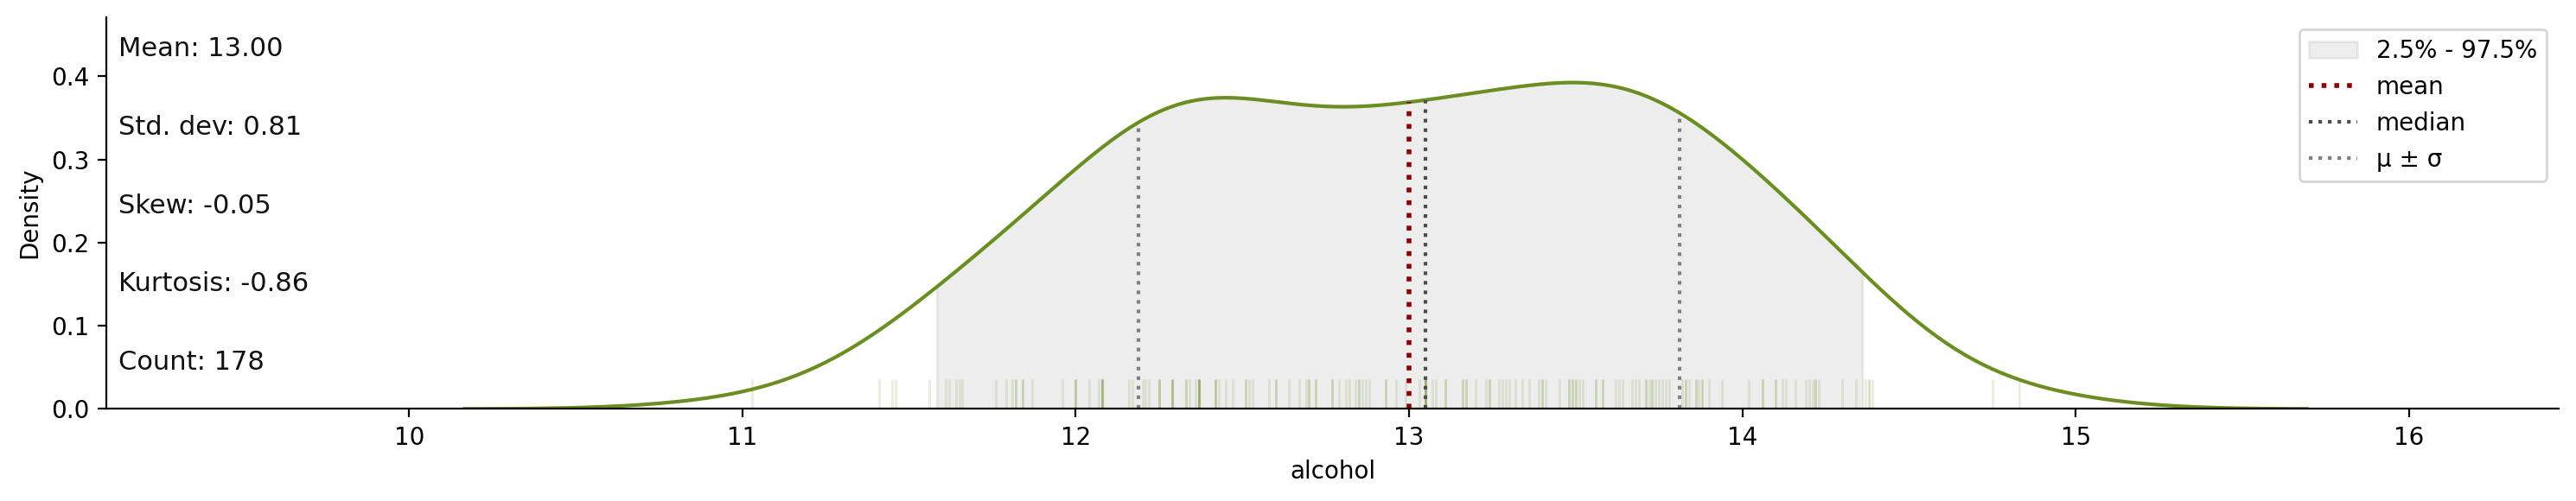

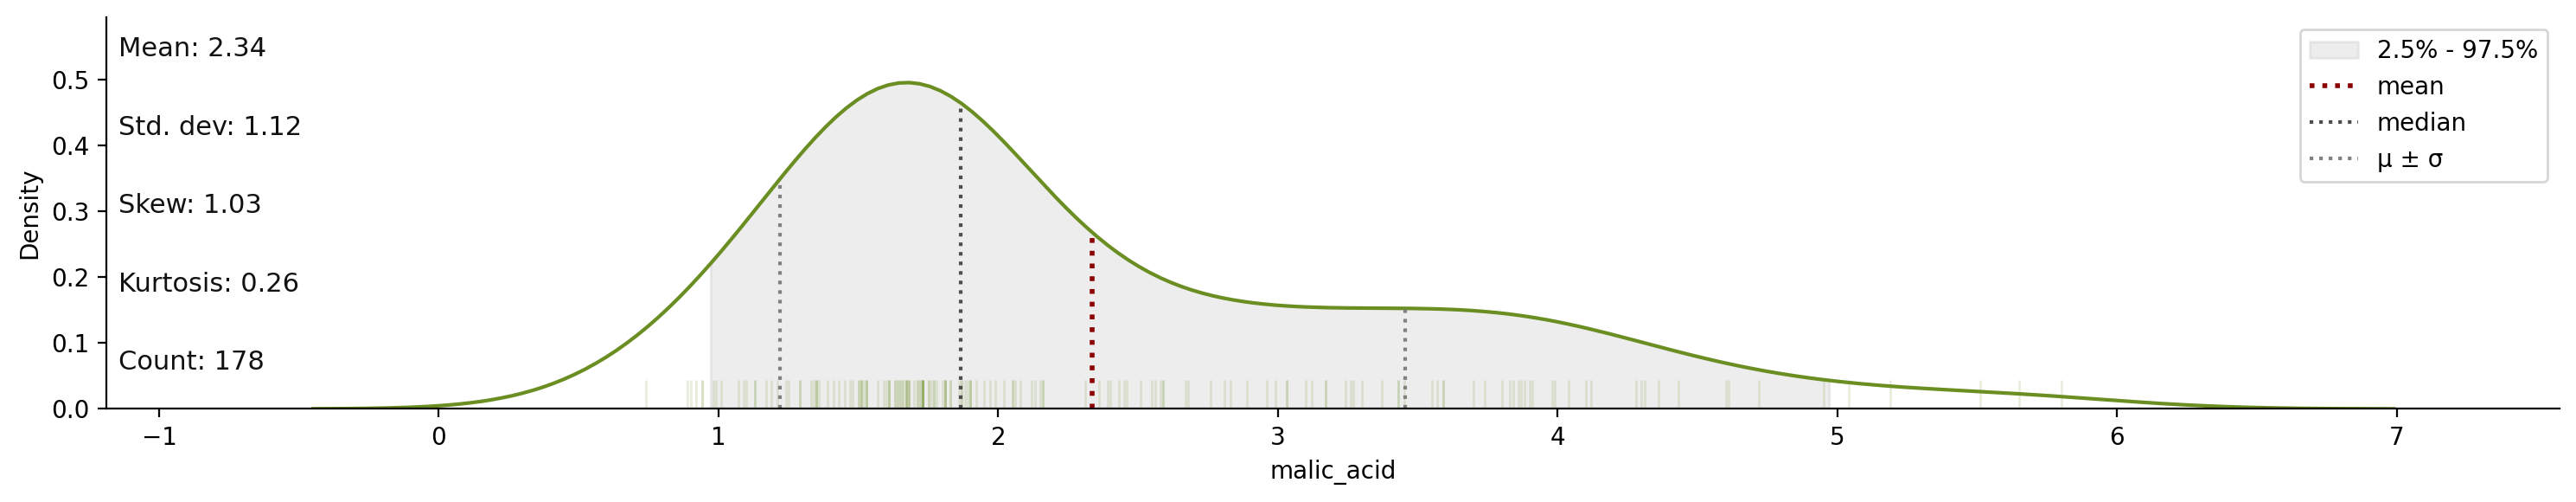

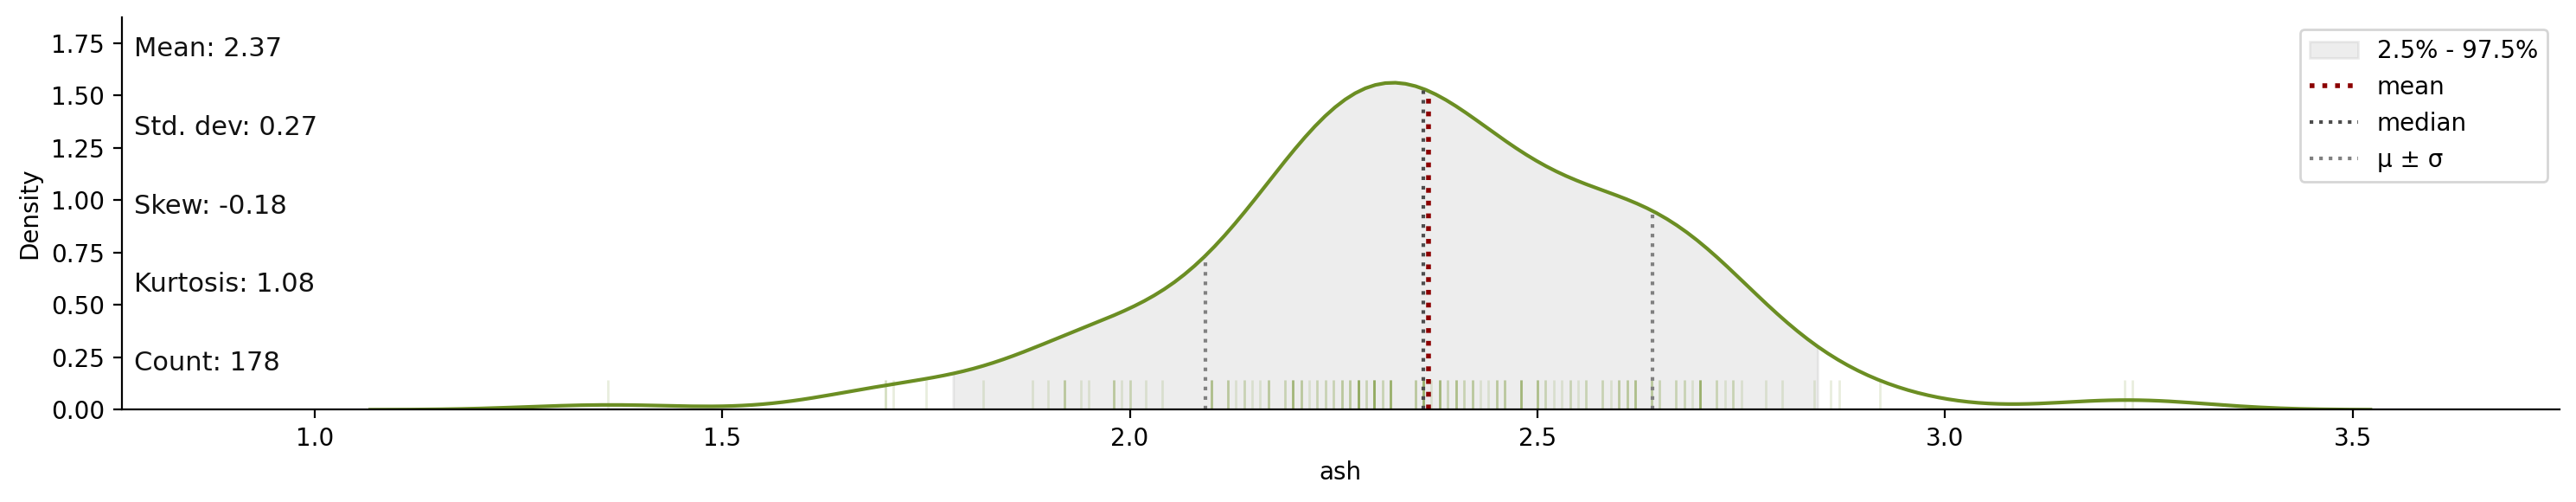

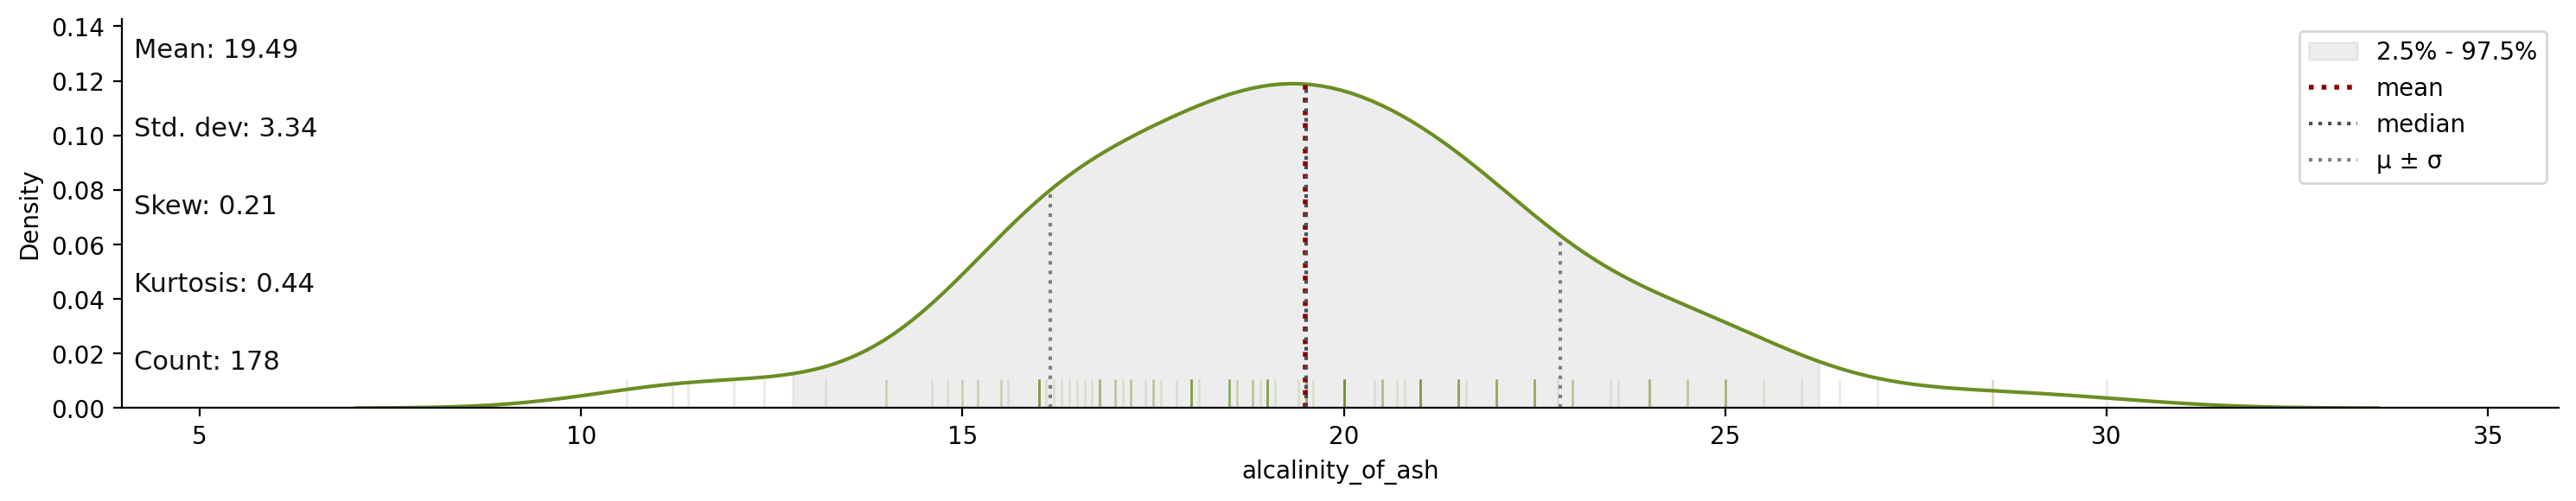

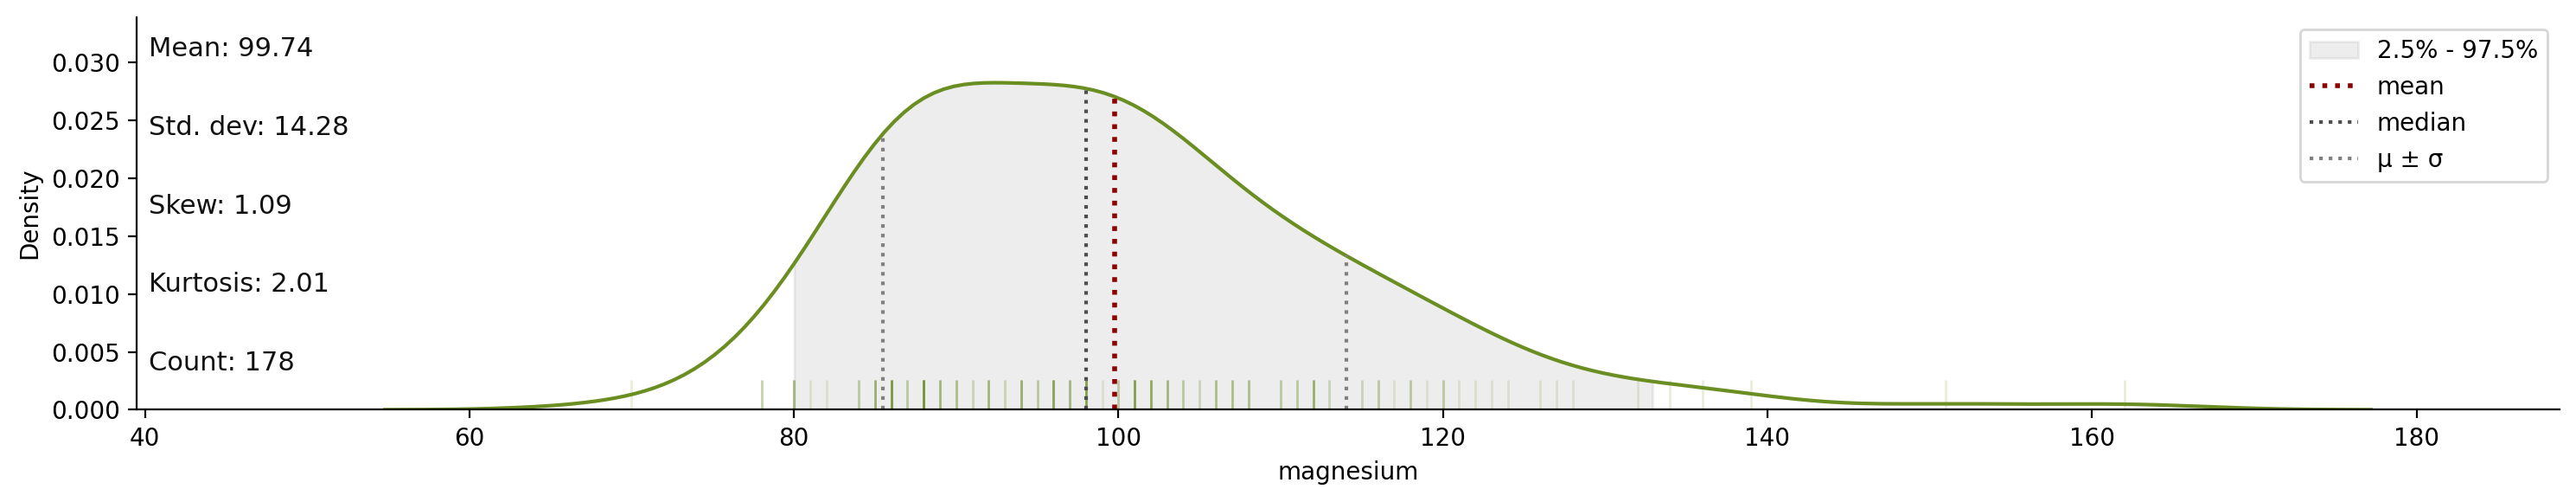

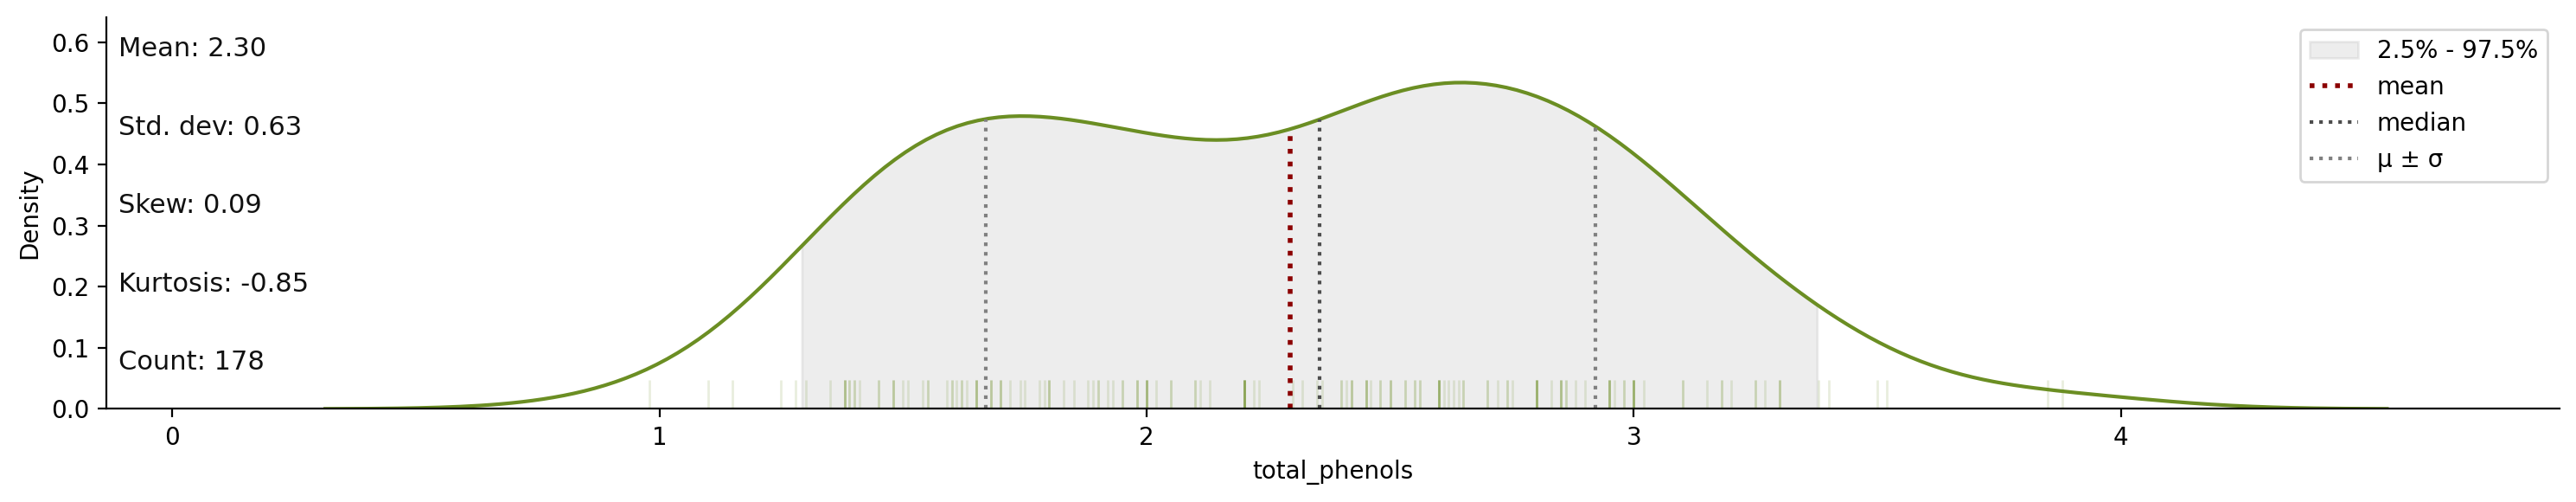

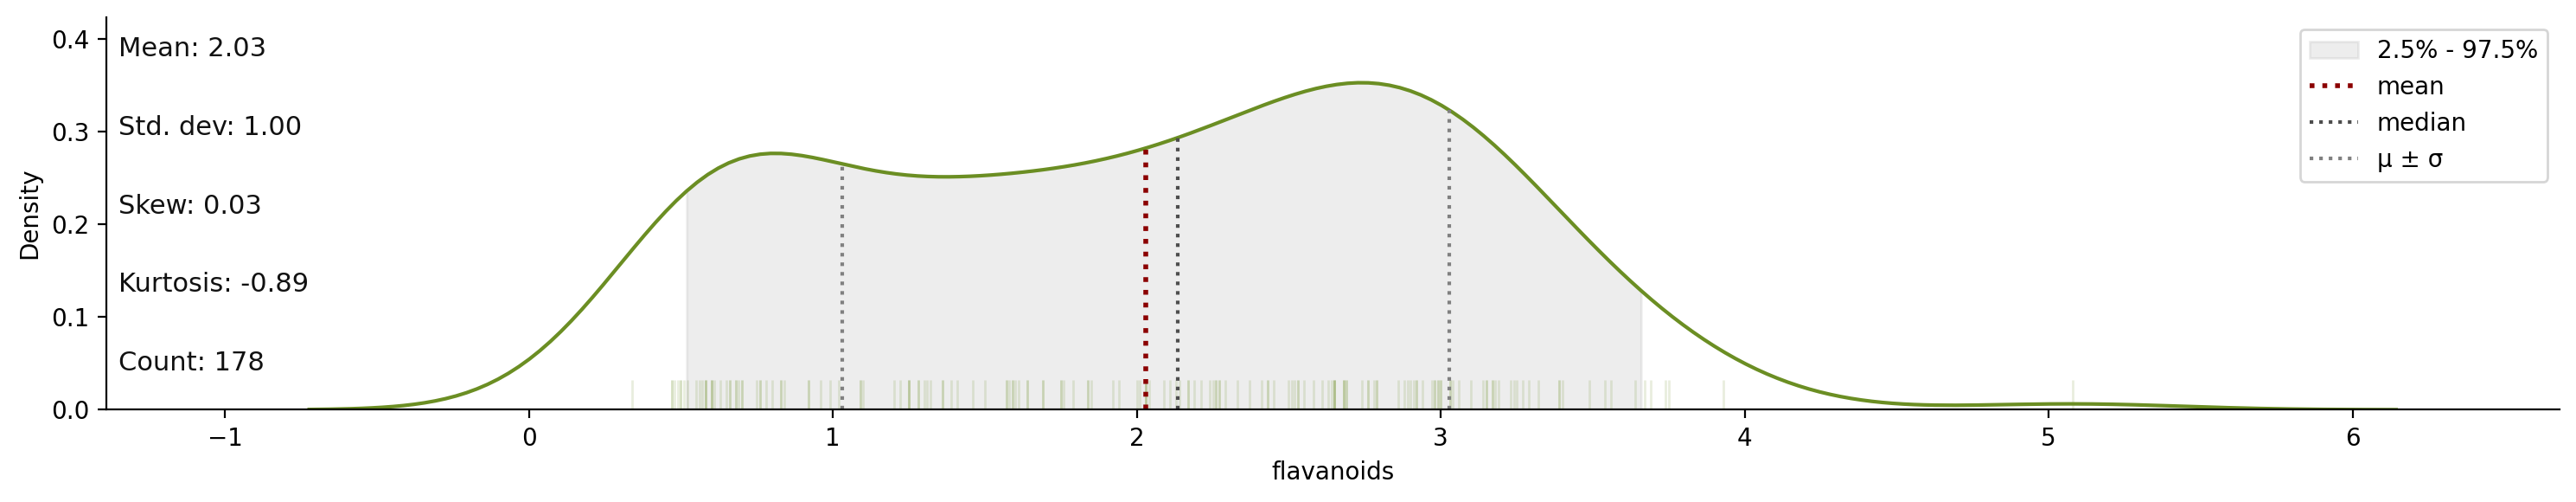

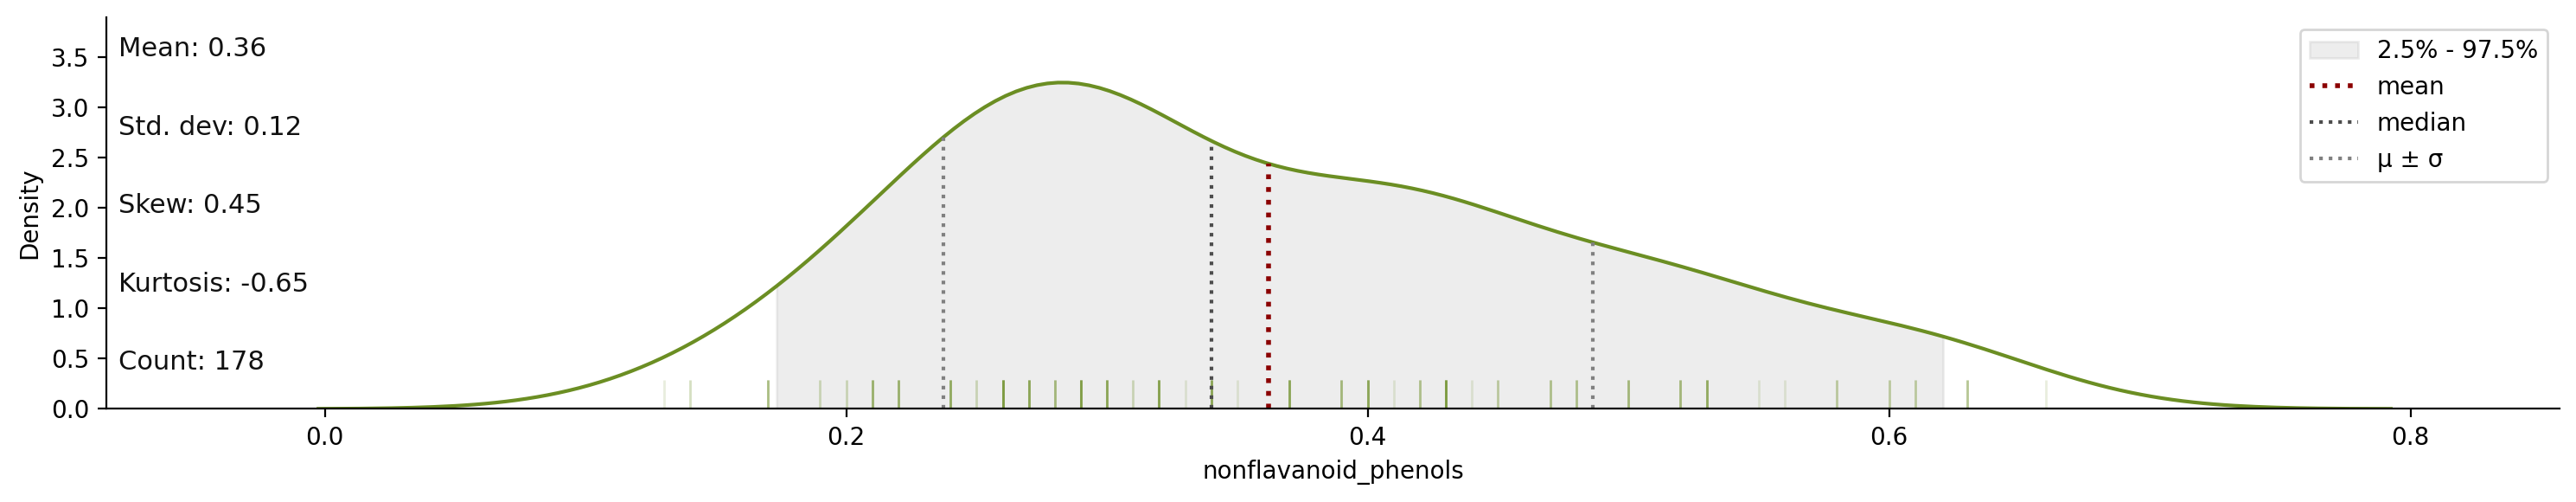

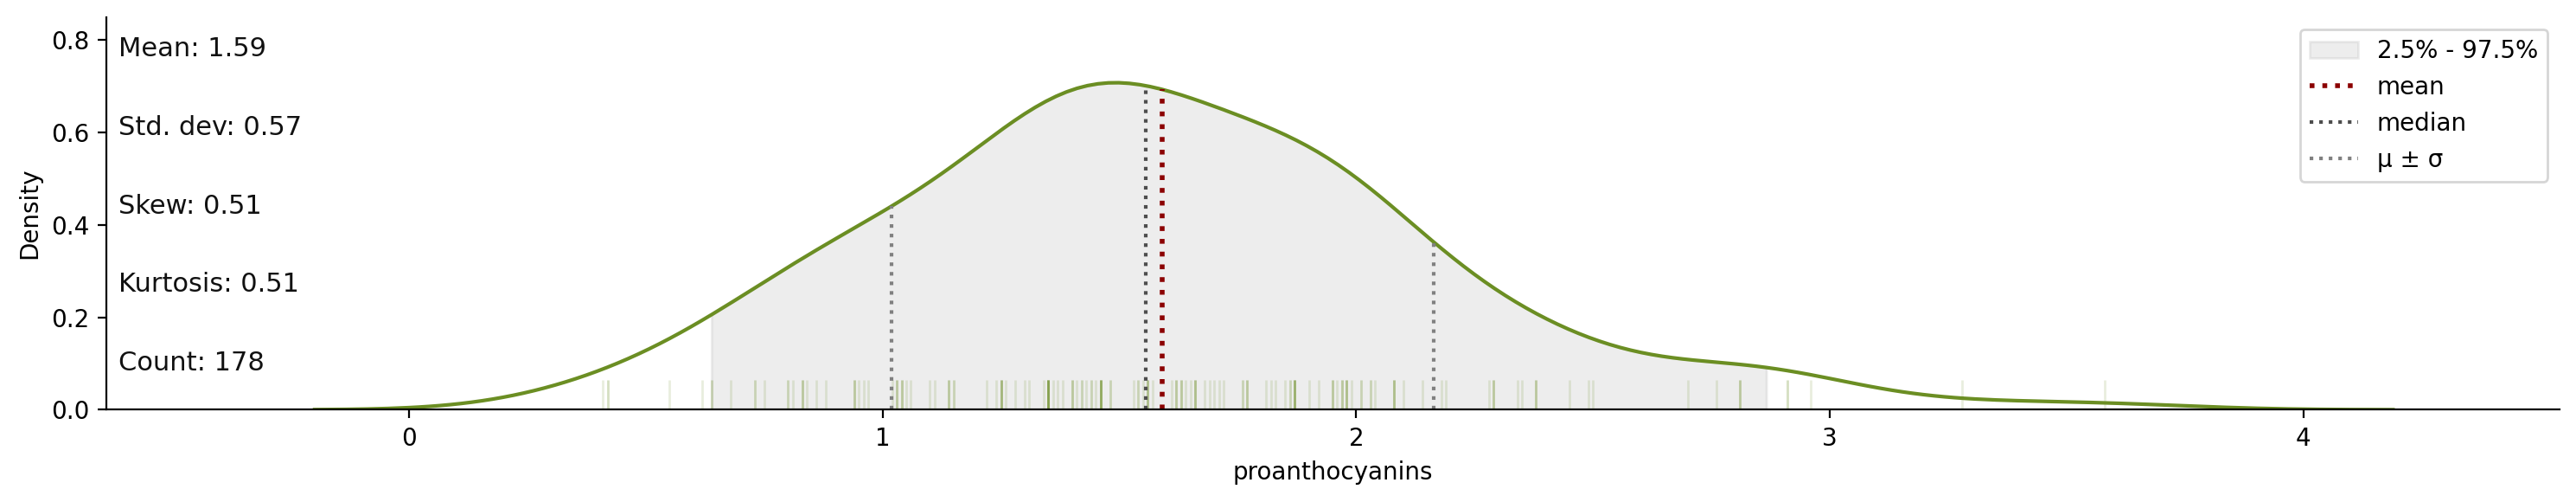

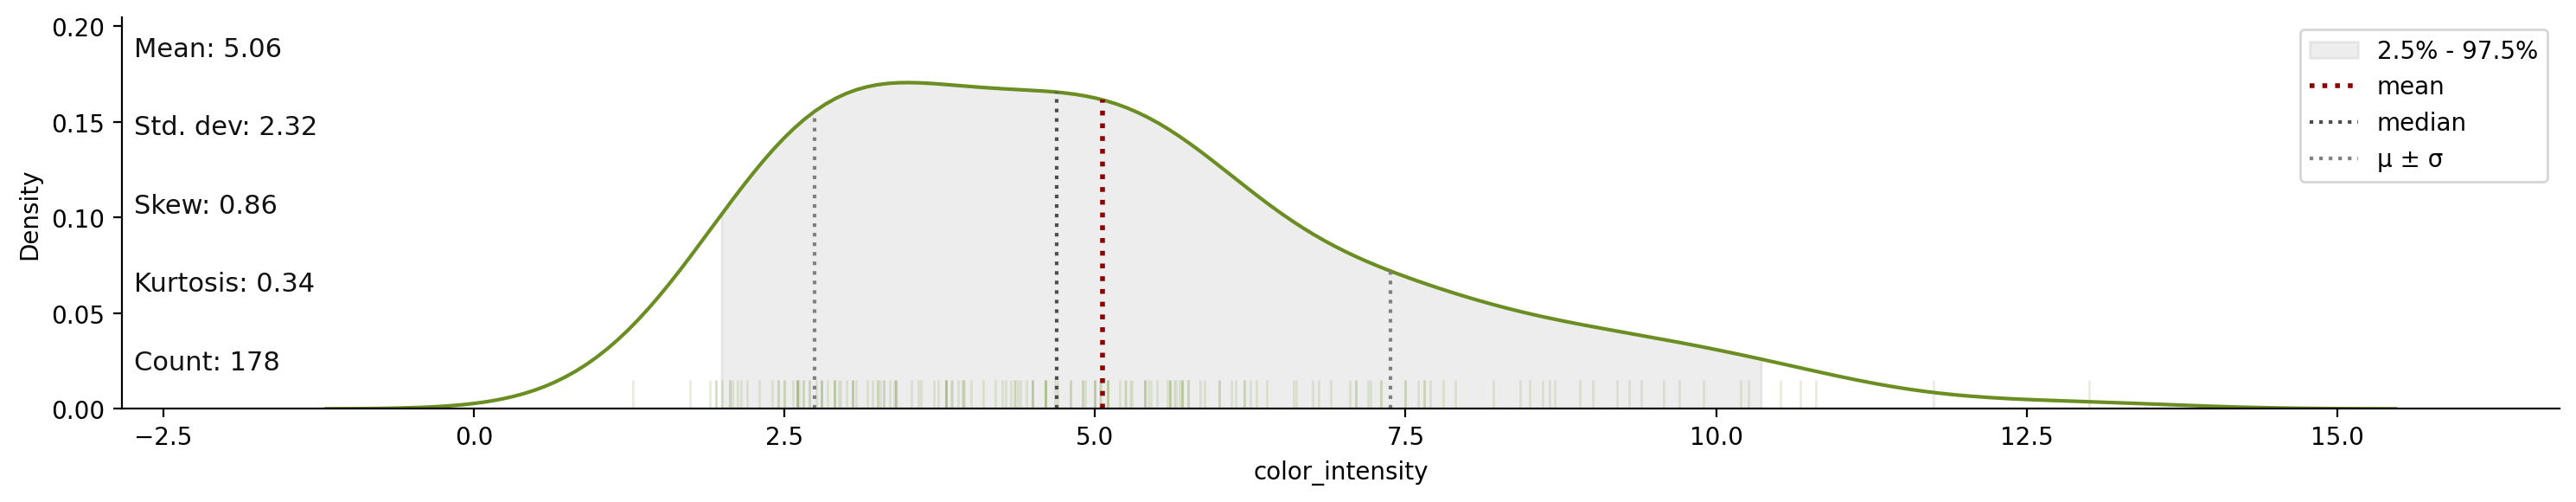

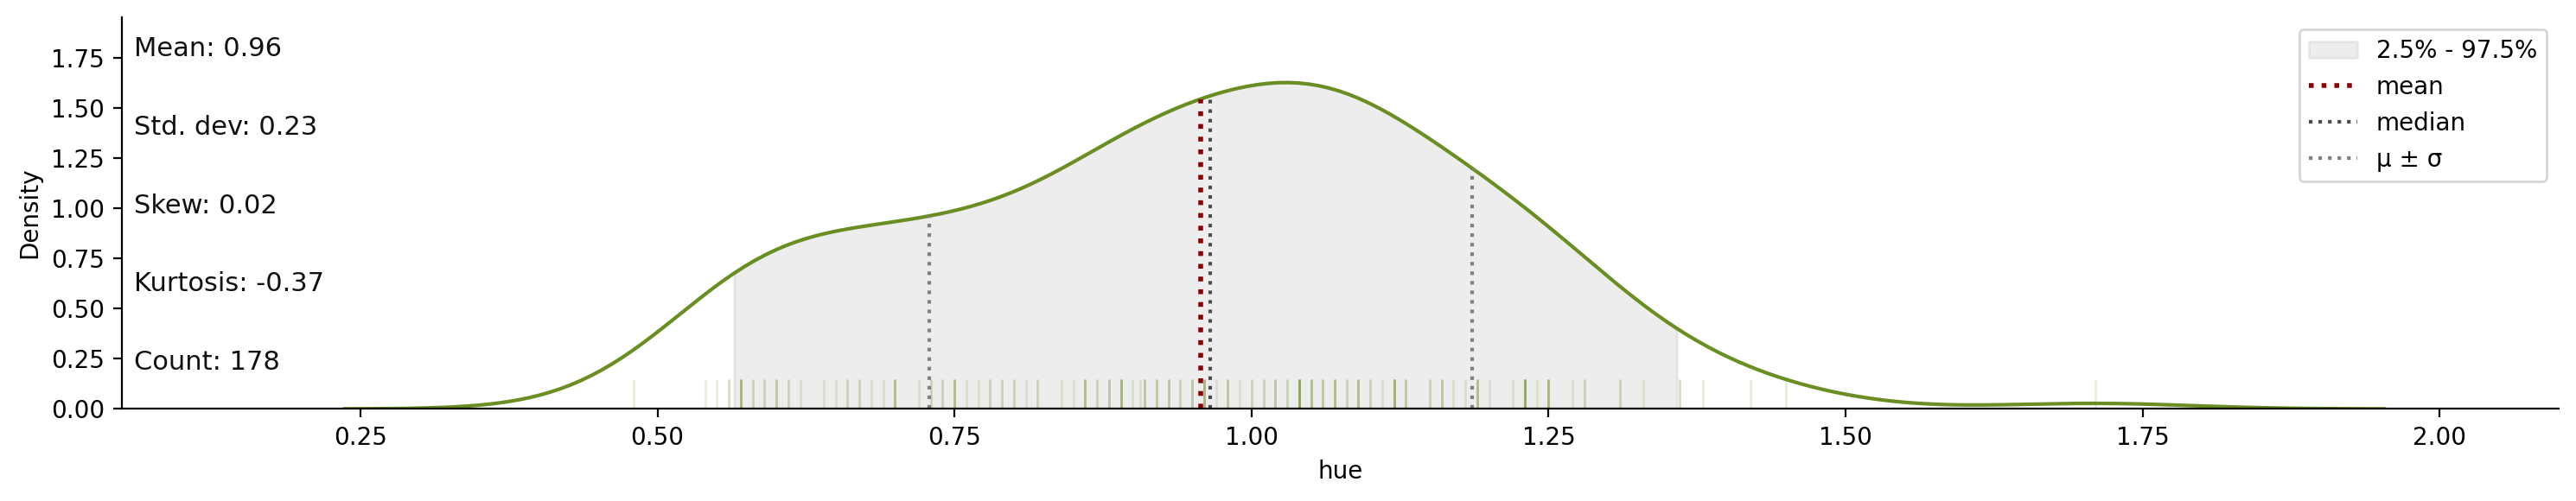

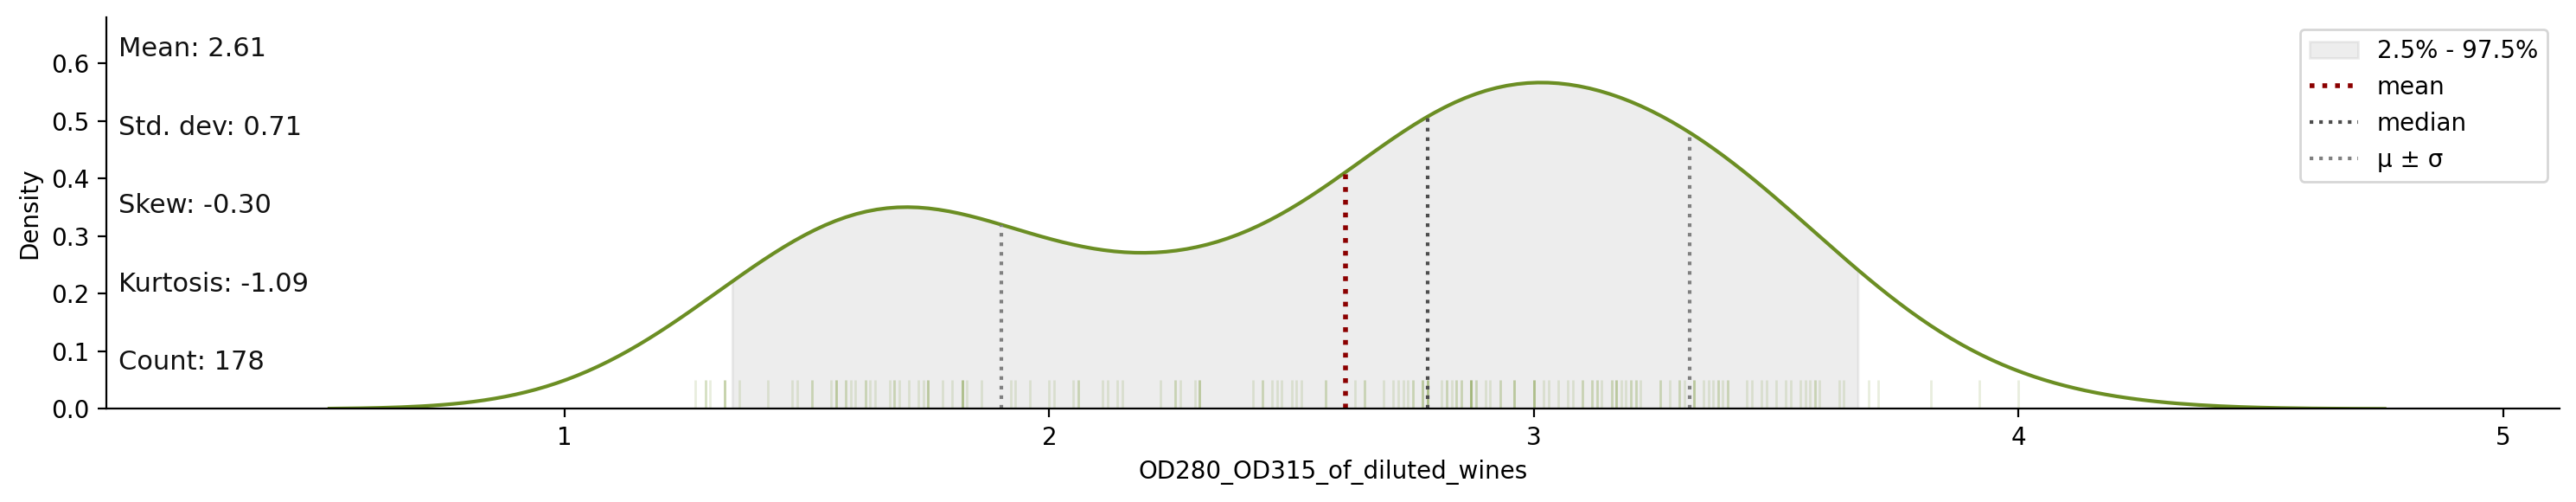

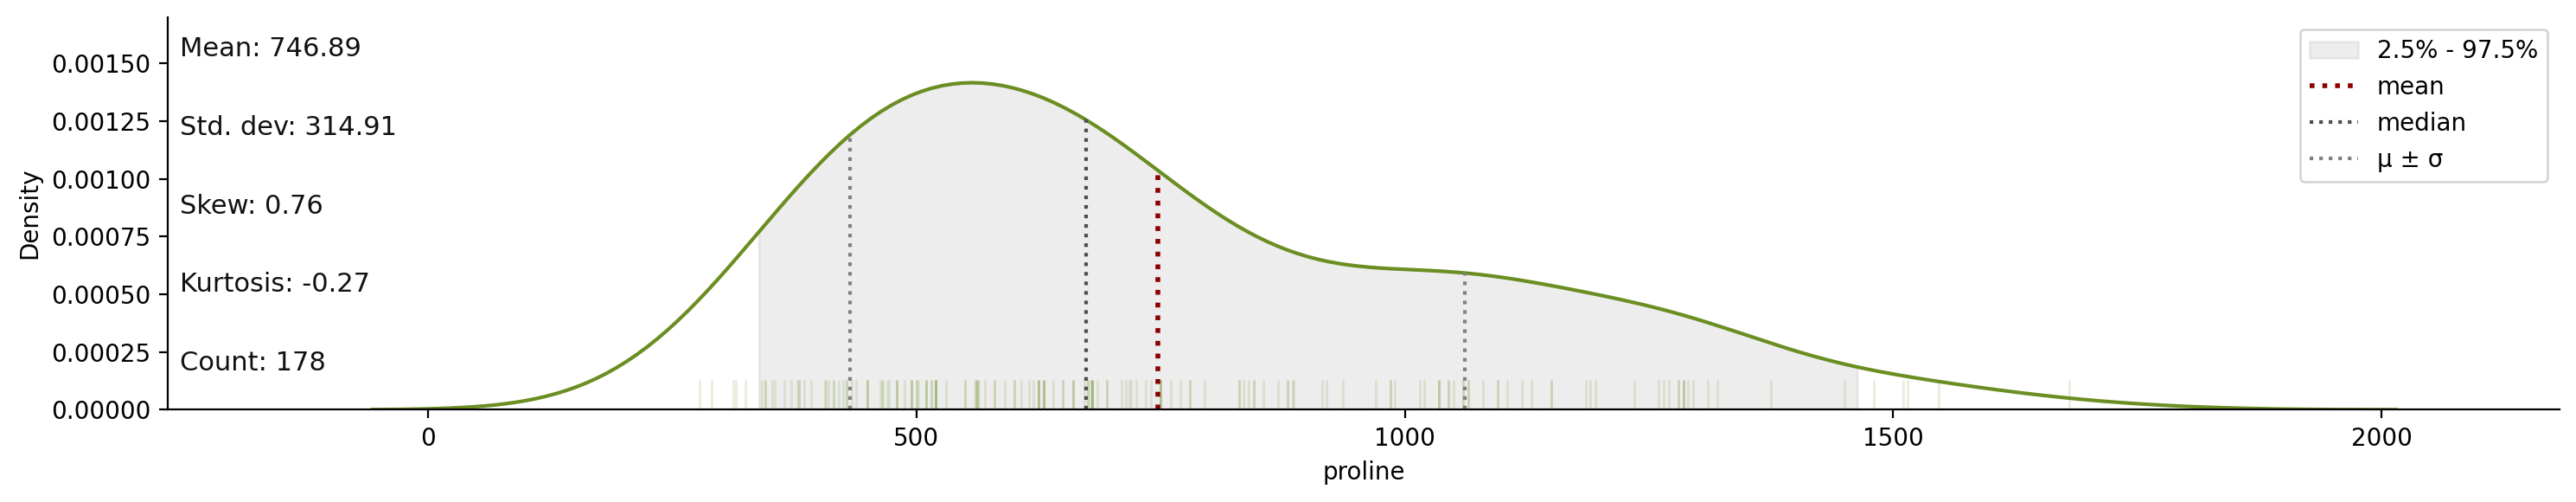

In [117]:
# Create distplot for all 
klib.dist_plot(df, showall=True, kde_kws = {'color': color_1}, 
                                        fill_kws = {'color': 'darkgrey', 'alpha': 0.2},
                                        rug_kws = {'color': color_2, 'alpha': 0.15, 'lw': 3, 'height': 0.075},
                                        mean_color = color_2
            )
plt.show()

### Impute Nulls

In [118]:
df.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
OD280_OD315_of_diluted_wines    0
proline                         0
dtype: int64

In [119]:
df = df.fillna(0)

### Variables

In [120]:
col_list = df.columns.tolist()
col_list = [c for c in col_list if c not in ['id']]

In [121]:
# Default pyod parameter, an estimate of the percentage of expected outliers
# Will use the probabilities instead of a threshold, but we need a value
contamination = 0.1

In [122]:
std_threshold = 3

In [123]:
anomaly_prob_threshold = 0.9

In [124]:
anomaly_ensemble_length = 5

In [125]:
# Set the voting threshold, at least this many votes
anomaly_voting_threshold = 2

### Scale

In [126]:
scaler = StandardScaler()
df[col_list] = scaler.fit_transform(df[col_list])

In [127]:
# scaler = StandardScaler()
# anomaly_df[col_list] = scaler.fit_transform(anomaly_df[col_list])

# Univariate Outliers
### Conditional Skew

In [128]:

# Start with only Inliers
df['outlier_flag'] = 0

# Iterate through each column
for col in col_list:

    # Check skew of data
    skewness = df[col].skew()

    # Passing on low cardinality
    if df[col].nunique() > 2:

        # For Normal data use z-score
        if (abs(skewness) <= 0.5):
            mean_val = df[col].mean()
            std_val = df[col].std()
            z_score = (df[col] - mean_val) / std_val
            df['outlier_flag'] = np.where(abs(z_score) > std_threshold, 1, df['outlier_flag'])
            df[col + '_outlier'] = np.where(abs(z_score) > std_threshold, 1, 0)

        # For moderately skewed data use modified z-score
        elif (abs(skewness) > 0.5) & (abs(skewness) <= 1):
            median_val = df[col].median()
            mad_val = mad(df[col]) 
            mod_z_score = 0.6745 * (df[col] - median_val) / mad_val
            df['outlier_flag'] = np.where((abs(mod_z_score) > (std_threshold + 0.5)), 1, df['outlier_flag'])
            df[col + '_outlier'] = np.where((abs(mod_z_score) > (std_threshold + 0.5)), 1, 0)

        # For highly skewed data use IQR
        else:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            # If there is a suitable range use IQR for highly skewed
            if IQR > 0:
                df['outlier_flag'] = np.where(((df[col] < (Q1 - (std_threshold/2) * IQR)) | (df[col] > (Q3 + (std_threshold/2) * IQR))), 1, df['outlier_flag'])
                df[col + '_outlier'] = np.where(((df[col] < (Q1 - (std_threshold/2) * IQR)) | (df[col] > (Q3 + (std_threshold/2) * IQR))), 1, 0)

            # For extreme skew log transform then use modified z-score
            else:
                # Determine the shift value. If data contains 0 or negative values,
                # we need to shift it so that min_shifted_value >= 0 for np.log1p(x) (where x is >=0)
                min_value = df[col].min()
                shift = 0
                if min_value < 0:
                    shift = abs(min_value) # Shift to make the smallest value 0
                elif min_value == 0:
                    shift = 1 # Shift by 1 if min value is 0, so 0 becomes 1 for log
                # Apply np.log1p or log(x + 1) to the shifted data 
                log_transformed = np.log1p(df[col] + shift)
                median_val = log_transformed.median()
                mad_val = mad(log_transformed)
                mod_z_score = 0.6745 * (log_transformed - median_val) / mad_val
                df['outlier_flag'] = np.where(abs(mod_z_score) > (std_threshold + 0.5), 1, df['outlier_flag'])
                df[col + '_outlier'] = np.where(abs(mod_z_score) > (std_threshold + 0.5), 1, 0)


In [129]:
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280_OD315_of_diluted_wines,proline,outlier_flag,alcohol_outlier,malic_acid_outlier,ash_outlier,alcalinity_of_ash_outlier,magnesium_outlier,total_phenols_outlier,flavanoids_outlier,nonflavanoid_phenols_outlier,proanthocyanins_outlier,color_intensity_outlier,hue_outlier,OD280_OD315_of_diluted_wines_outlier,proline_outlier
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952,1,0,1,0,0,0,0,0,0,0,0,0,0,0
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893,0,0,0,0,0,0,0,0,0,0,0,0,0,0
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575,0,0,0,0,0,0,0,0,0,0,0,0,0,0
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Multivariate Anomalies
### Voting Ensemble

In [130]:
df['ecod_anomaly'] = 0

# ecod
ecod = ECOD(contamination=contamination)
ecod.fit(df[col_list])
ecod_labels = ecod.labels_ 
# Use predicted probs rather than contamination threshold
ecod_pred_proba = ecod.predict_proba(df[col_list])[:, 1]
is_anomaly = ecod_pred_proba> anomaly_prob_threshold 
df['ecod_anomaly'] = np.where((is_anomaly == True), 
                                        1, 
                                        df['ecod_anomaly'])        
        

In [131]:
df['lof_anomaly'] = 0

# lof
lof = LOF(contamination=contamination)
lof.fit(df[col_list])
lof_labels = lof.labels_ 
# Use predicted probs rather than contamination threshold
lof_pred_proba = lof.predict_proba(df[col_list])[:, 1]
is_anomaly = lof_pred_proba > anomaly_prob_threshold 
df['lof_anomaly'] = np.where((is_anomaly == True), 
                                        1, 
                                        df['lof_anomaly'])   

In [132]:
df['iforest_anomaly'] = 0
    
# iforest
iforest = IForest(contamination=contamination)
iforest.fit(df[col_list])
iforest_labels = iforest.labels_ 
# Use predicted probs rather than contamination threshold
iforest_pred_proba = iforest.predict_proba(df[col_list])[:, 1]
is_anomaly = iforest_pred_proba > anomaly_prob_threshold 
df['iforest_anomaly'] = np.where((is_anomaly == True), 
                                        1, 
                                        df['iforest_anomaly'])   

/Users/sam/opt/anaconda3/envs/anomaly_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [133]:
df['ocsvm_anomaly'] = 0
    
# OCSVM
ocsvm = OCSVM(contamination=contamination)
ocsvm.fit(df[col_list])
ocsvm_labels = ocsvm.labels_ 
# Use predicted probs rather than contamination threshold
ocsvm_pred_proba = ocsvm.predict_proba(df[col_list])[:, 1]
is_anomaly = ocsvm_pred_proba > anomaly_prob_threshold 
df['ocsvm_anomaly'] = np.where((is_anomaly == True), 
                                        1, 
                                        df['ocsvm_anomaly'])   

/Users/sam/opt/anaconda3/envs/anomaly_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


In [134]:
df['autoencoder_anomaly'] = 0

# The number of features must be greater than the number of neurons in the hidden layers
num_cols = df[col_list].shape[1]
    
# AutoEncoder
try:
    ae = AutoEncoder(contamination=contamination, verbose=0)
    ae.fit(df[col_list])
except:
    ae = AutoEncoder(contamination=contamination, verbose=0, hidden_neuron_list=[num_cols, num_cols/2, num_cols/2, num_cols])
    ae.fit(df[col_list])    


ae_labels = ae.labels_ 
# Use predicted probs rather than contamination threshold
ae_pred_proba = ae.predict_proba(df[col_list])[:, 1]
is_anomaly = ae_pred_proba > anomaly_prob_threshold 
df['autoencoder_anomaly'] = np.where((is_anomaly == True), 
                                        1, 
                                        df['autoencoder_anomaly'])   

# Post Processing

In [135]:
# Total number of outlier metrics per record
df['total_outliers'] = df[[c for c in df.columns if c.endswith('_outlier')]].sum(axis=1)

In [136]:
# Total outliers / number of metrics
df['outlier_score'] = df['total_outliers'] / len(col_list)

In [137]:
# Total the ensemble
df['total_anomaly'] = (df['ecod_anomaly'] + \
                        df['lof_anomaly'] + \
                        df['iforest_anomaly'] + \
                        df['ocsvm_anomaly'] + \
                        df['autoencoder_anomaly'])

In [138]:
# Total anomalies / number of anomaly algorithms
df['anomaly_score'] = df['total_anomaly'] / anomaly_ensemble_length

In [139]:
# Avg anomaly predicted probability
df['anomaly_avg_prob'] = np.mean([ecod_pred_proba, lof_pred_proba, iforest_pred_proba, ocsvm_pred_proba, ae_pred_proba], axis=0)

In [140]:
# Anomaly flag
df['anomaly_flag'] = np.where((df['total_anomaly'] >= anomaly_voting_threshold), 
                                1, 
                                0)    

In [141]:
# Outlier or Anomaly flag
conditions = [
            (df['outlier_flag'] == 1) & (df['anomaly_flag'] == 1),
            (df['outlier_flag'] == 1) & (df['anomaly_flag'] == 0),
            (df['outlier_flag'] == 0) & (df['anomaly_flag'] == 1),
            ]

choices = ['both', 'outlier', 'anomaly']

df['outlier_or_anomaly_flag'] = np.select(conditions, choices, 'none')

In [142]:
# Inverse transform metrics
df[col_list] = scaler.inverse_transform(df[col_list])

In [143]:
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280_OD315_of_diluted_wines,proline,outlier_flag,alcohol_outlier,malic_acid_outlier,ash_outlier,alcalinity_of_ash_outlier,magnesium_outlier,total_phenols_outlier,flavanoids_outlier,nonflavanoid_phenols_outlier,proanthocyanins_outlier,color_intensity_outlier,hue_outlier,OD280_OD315_of_diluted_wines_outlier,proline_outlier,ecod_anomaly,lof_anomaly,iforest_anomaly,ocsvm_anomaly,autoencoder_anomaly,total_outliers,outlier_score,total_anomaly,anomaly_score,anomaly_avg_prob,anomaly_flag,outlier_or_anomaly_flag
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.0,0.314758,0,none
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.0,0.263095,0,none
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.0,0.216665,0,none
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.0,0.421187,0,none
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.0,0.173101,0,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.076923,0,0.0,0.314402,0,outlier
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.0,0.135346,0,none
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.0,0.322975,0,none
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.0,0.249130,0,none


# Venn Diagram

In [144]:
print('TOTAL OUTLIERS: ', df.shape[0] - df[~(df['outlier_flag'] == 1)].shape[0])
print('ONLY OUTLIERS: ', df.shape[0] - df[~(df['outlier_or_anomaly_flag'] == 'outlier')].shape[0])
print('TOTAL ANOMALIES: ', df.shape[0] - df[~(df['anomaly_flag'] == 1)].shape[0])
print('ONLY ANOMALES: ', df.shape[0] - df[~(df['outlier_or_anomaly_flag'] == 'anomaly')].shape[0])
print('BOTH OUTLIERS and ANOMALIES: ', df.shape[0] - df[~(df['outlier_or_anomaly_flag'] == 'both')].shape[0])

TOTAL OUTLIERS:  13
ONLY OUTLIERS:  10
TOTAL ANOMALIES:  3
ONLY ANOMALES:  0
BOTH OUTLIERS and ANOMALIES:  3


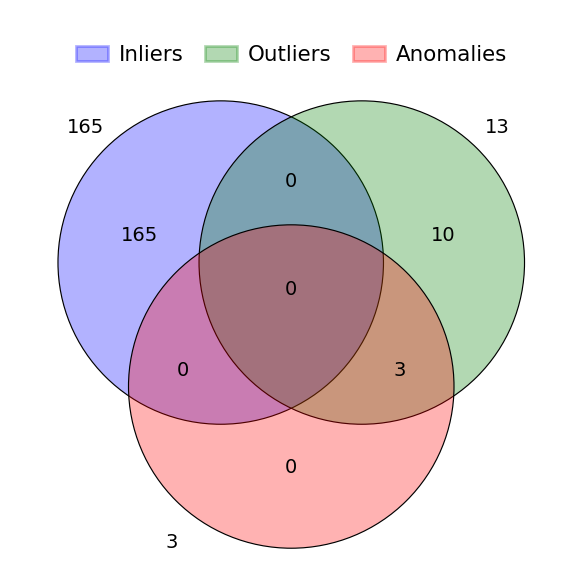

In [145]:
#dict of sets
sets = {
    'Inliers': set(df[(df['outlier_flag'] == 0)&(df['anomaly_flag'] == 0)].index.tolist()),
    'Outliers': set(df[df['outlier_flag'] == 1].index.tolist()),
    'Anomalies': set(df[df['anomaly_flag'] == 1].index.tolist()),
}


    
venny4py(sets=sets)

In [146]:
df.query("outlier_or_anomaly_flag == 'both'")

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280_OD315_of_diluted_wines,proline,outlier_flag,alcohol_outlier,malic_acid_outlier,ash_outlier,alcalinity_of_ash_outlier,magnesium_outlier,total_phenols_outlier,flavanoids_outlier,nonflavanoid_phenols_outlier,proanthocyanins_outlier,color_intensity_outlier,hue_outlier,OD280_OD315_of_diluted_wines_outlier,proline_outlier,ecod_anomaly,lof_anomaly,iforest_anomaly,ocsvm_anomaly,autoencoder_anomaly,total_outliers,outlier_score,total_anomaly,anomaly_score,anomaly_avg_prob,anomaly_flag,outlier_or_anomaly_flag
59,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0.076923,2,0.4,0.829082,1,both
95,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0.076923,2,0.4,0.672113,1,both
121,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,2,0.153846,5,1.0,0.989048,1,both


# Box and Swarm Plots

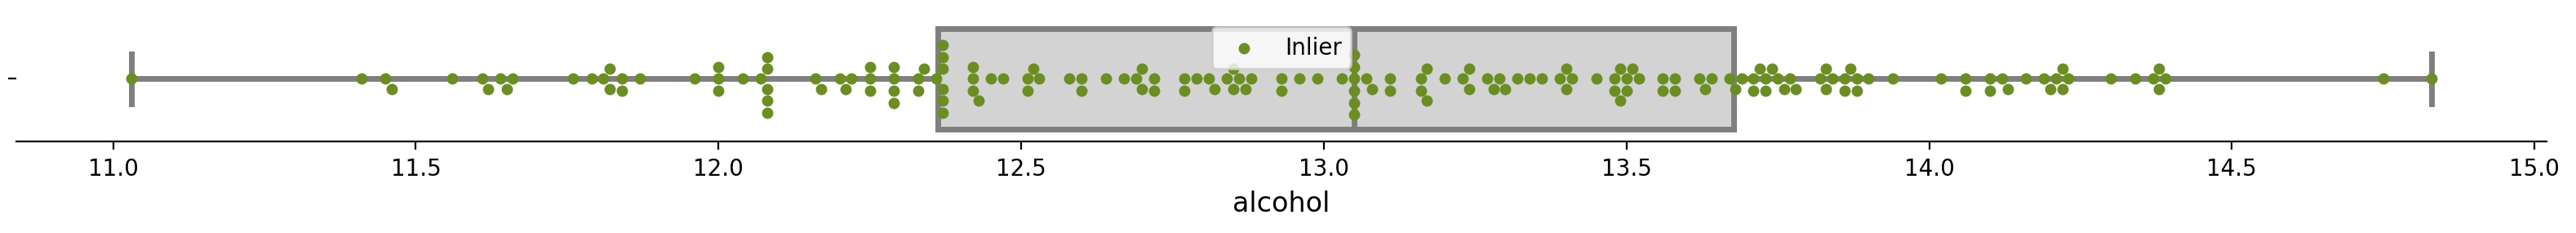

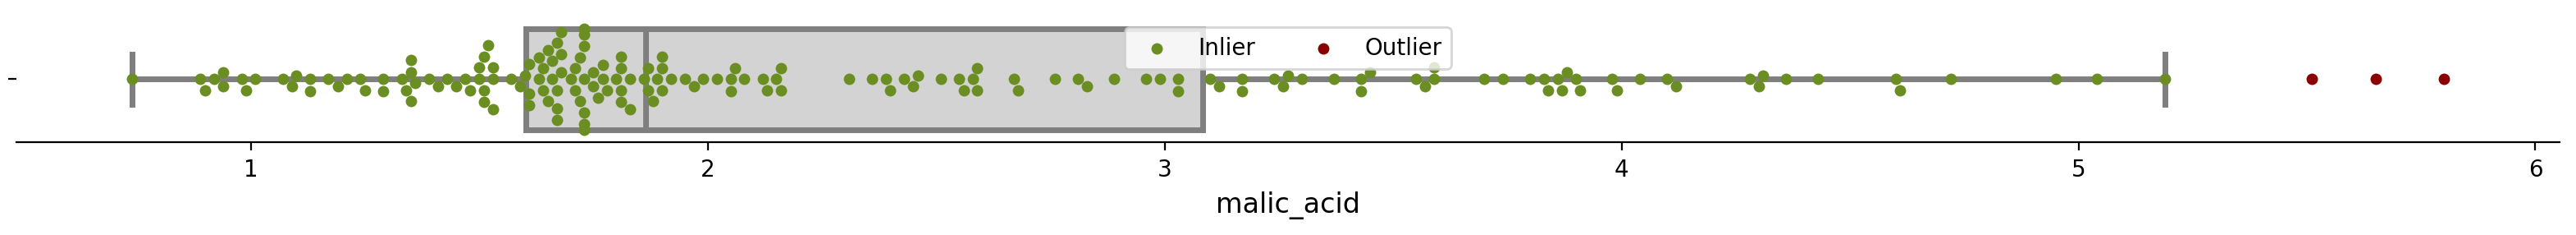

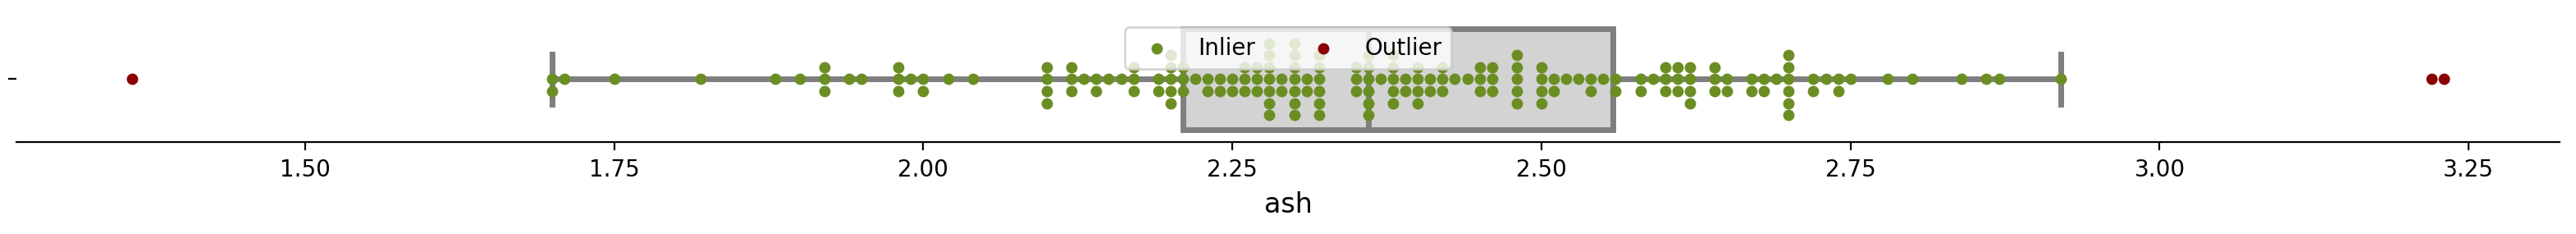

/Users/sam/opt/anaconda3/envs/anomaly_env/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


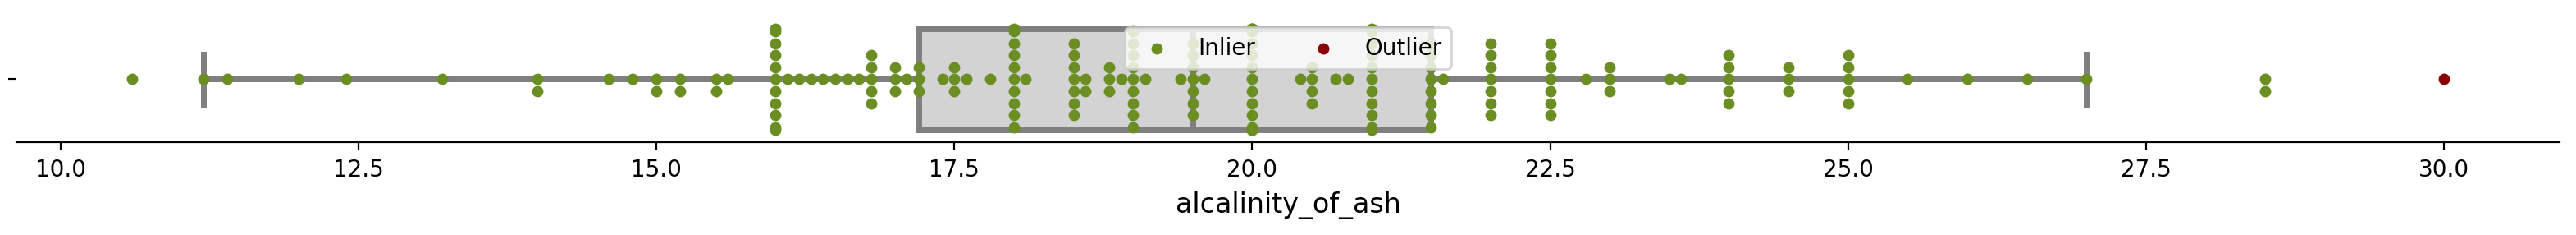

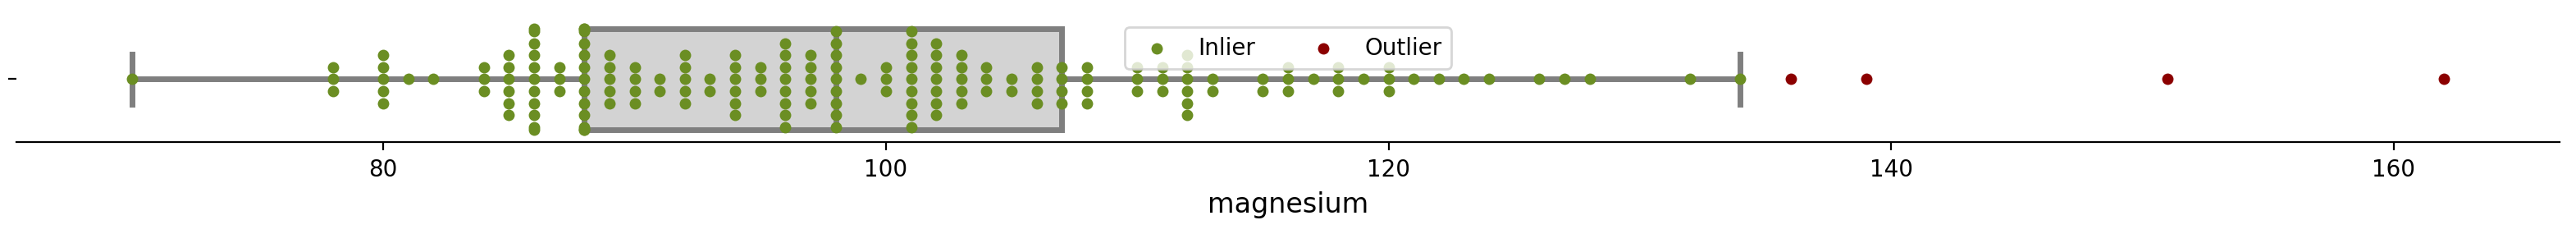

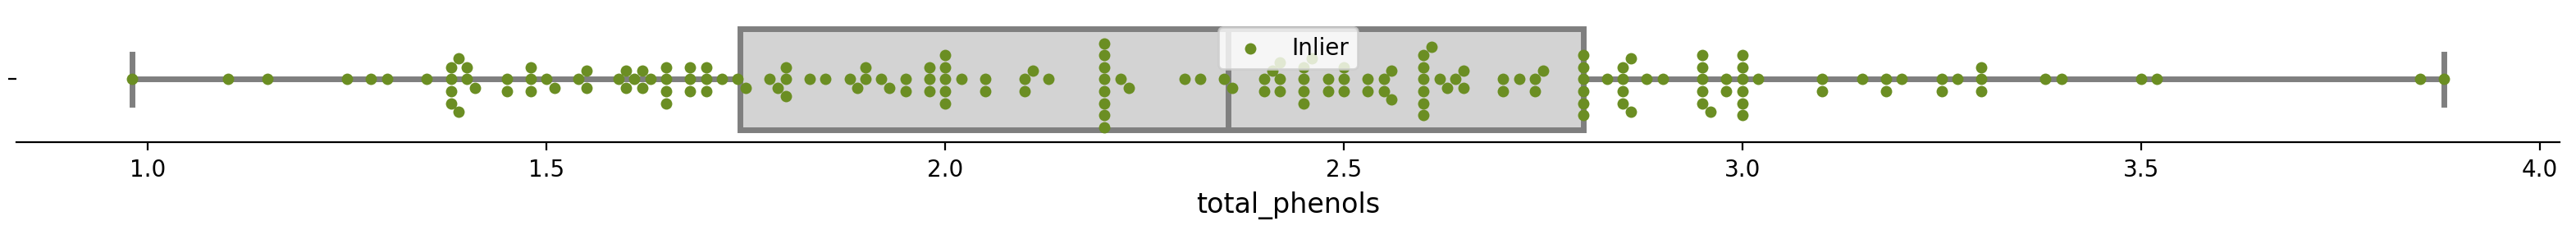

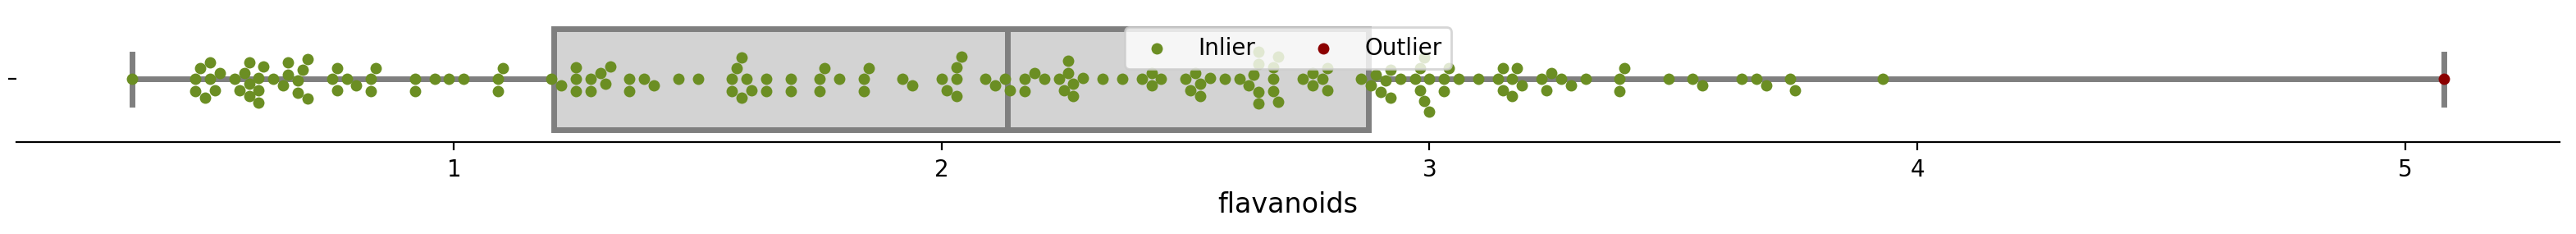

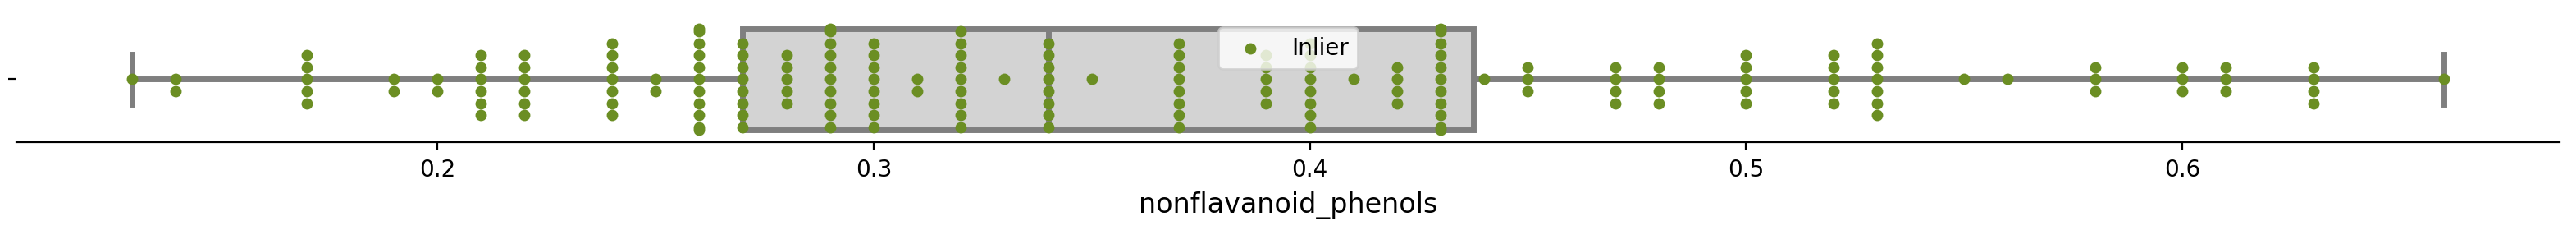

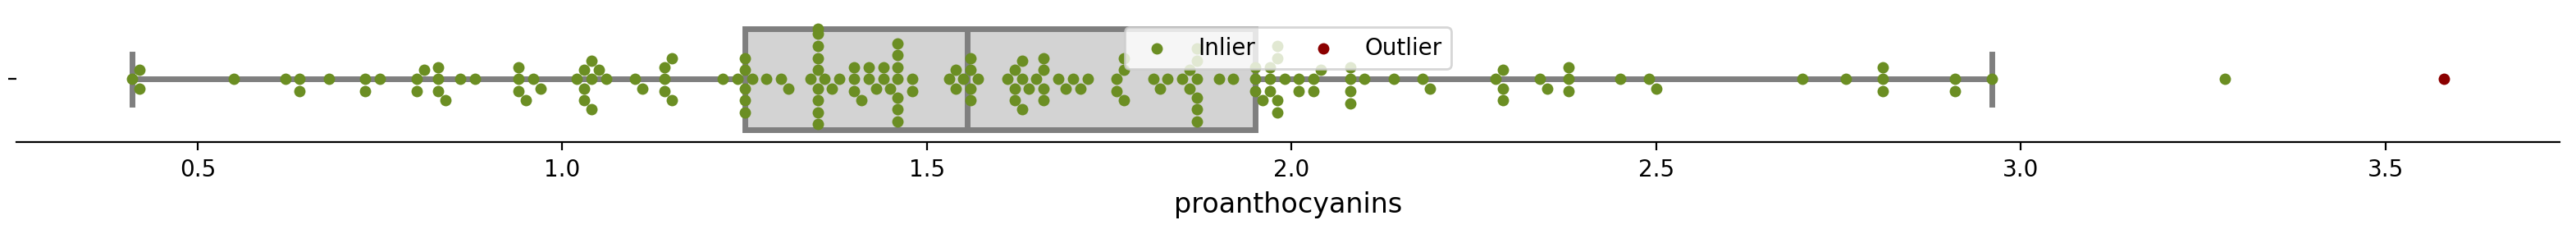

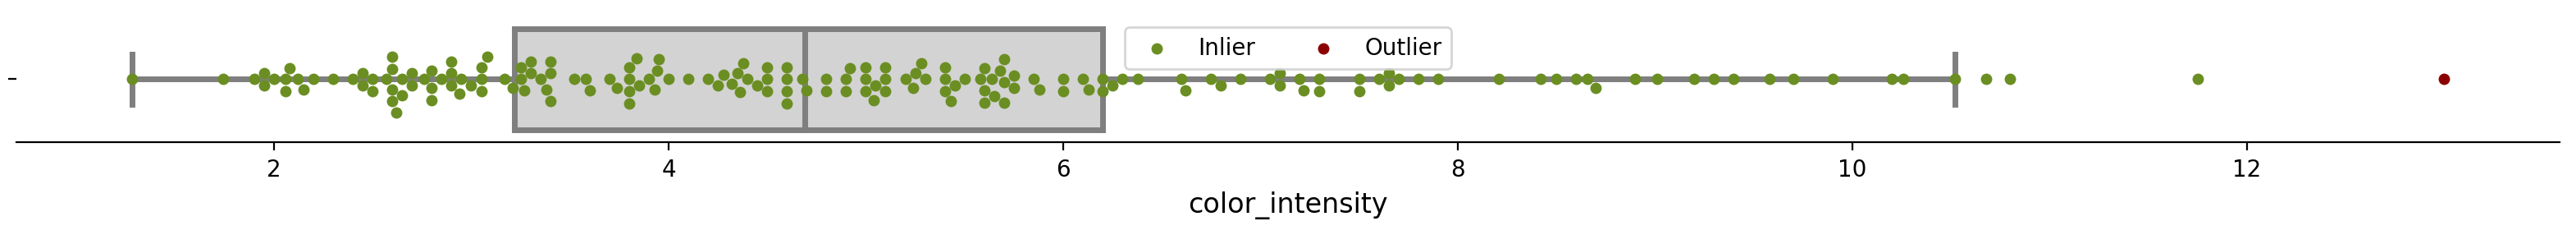

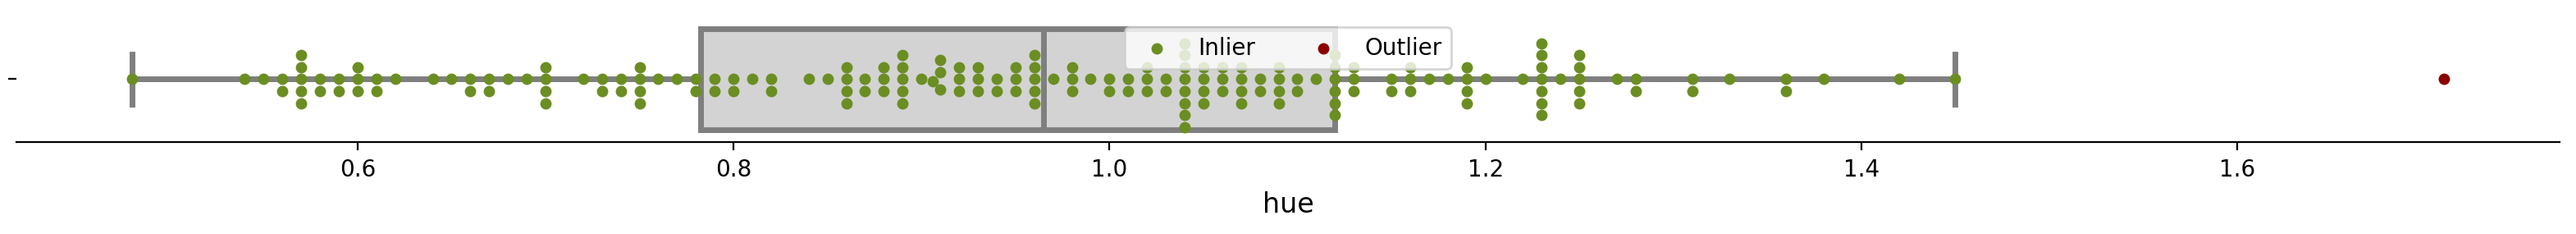

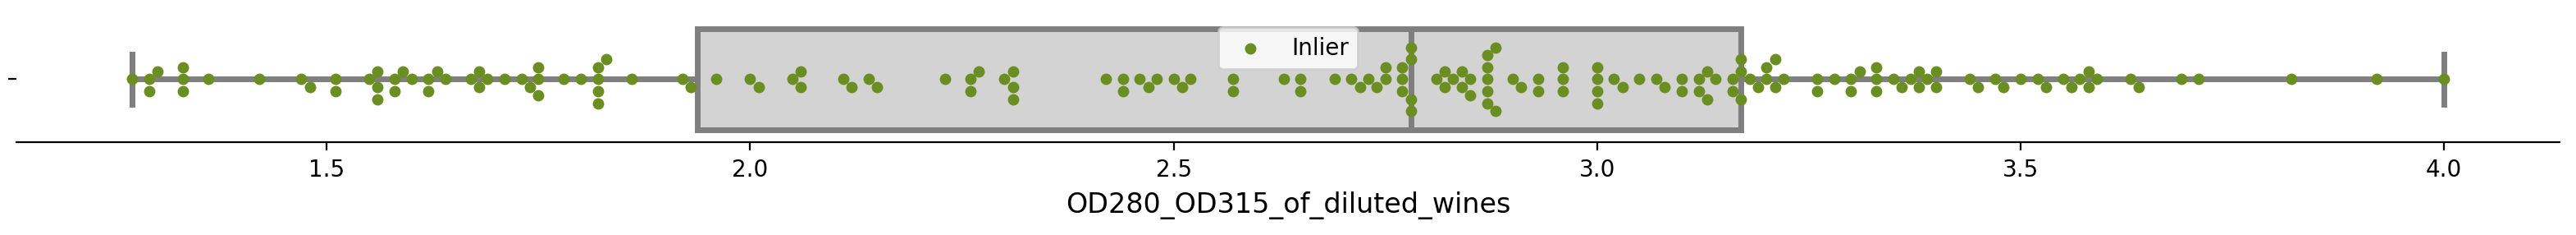

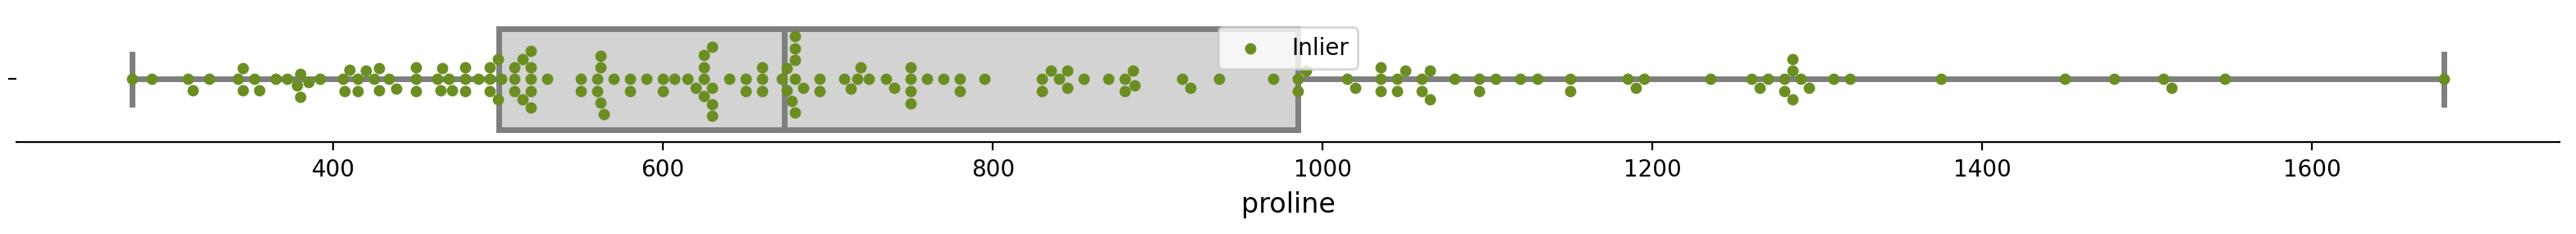

In [147]:
for metric in col_list:
    plt.figure(figsize=(20,1))
    sns.swarmplot(x = f'{metric}', data = df[df[f'{metric}_outlier']==0],  color=color_1, size=5, label='Inlier')
    sns.boxplot(  x = f'{metric}', data = df, orient = 'h', color = 'lightgrey', showfliers = False, linewidth = 2.5)
    sns.swarmplot(x = f'{metric}', data = df[df[f'{metric}_outlier']==1],  color=color_2, size=5, label='Outlier')
    plt.legend(loc='upper center', ncols=3)
    plt.xlabel(f'{metric}', size=12)
    # plt.title(f'{metric} Outliers', size=16)
    plt.show()

### Manual Corrections

In [148]:
df['alcalinity_of_ash' + '_stat_outlier'] = np.where( df['alcalinity_of_ash'] > 27.5 ,
                                                    1, 
                                                    df['alcalinity_of_ash' + '_outlier'])


df['proline' + '_stat_outlier'] = np.where( df['proline'] >= 1600 ,
                                                    1, 
                                                    df['proline' + '_outlier'])